<a href="https://colab.research.google.com/github/jwang44/upgraded-octo-chainsaw/blob/main/Load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chainsaw

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/imageunderstanding'

/content/drive/MyDrive/imageunderstanding


In [3]:
!ls

ExampleSubmissionRandom.csv  Test.pkl	       Train.pkl
Load_data.ipynb		     Train_labels.csv


In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import torch

In [4]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## Visualize some images (can skip)

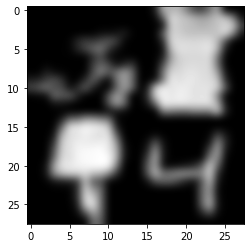

In [21]:
# Read a pickle file and display its samples
data = pickle.load( open( 'Train.pkl', 'rb' ))
targets = np.genfromtxt('Train_labels.csv', delimiter=',', skip_header=1, usecols=1)
# data = np.squeeze(data,axis=1)
plt.imshow(data[2][0], cmap='gray', interpolation="bicubic")
plt.show()

In [22]:
print("data_shape: ", data.shape)
print("targets_shape: ", targets.shape)

data_shape:  (60000, 1, 28, 28)
targets_shape:  (60000,)


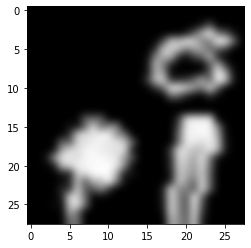

In [24]:
plt.imshow(data[1930][0], cmap='gray', interpolation="bicubic")
plt.show()



## Load data

In [5]:
# Read image data and their label into a Dataset 
data = pickle.load( open( 'Train.pkl', 'rb' ))
# this line is changed to 
# 1. make sure data and targets are of the same dimension
# 2. drop the index column
targets = np.genfromtxt('Train_labels.csv', delimiter=',', skip_header=1, usecols=1)

In [6]:
# convert targets to one-hot OPTIONAL
from sklearn.preprocessing import OneHotEncoder

print("targets shape: ", targets.shape)
one_hot = OneHotEncoder(sparse=False)
targets = one_hot.fit_transform(targets.reshape(-1,1))
print("targets shape: ", targets.shape)

targets shape:  (60000,)
targets shape:  (60000, 10)


In [6]:
data = torch.from_numpy(data)
targets = torch.from_numpy(targets)
dataset = TensorDataset(data,targets)

In [7]:
print("data_shape: ", data.shape)
print("target_shape: ", targets.shape)
print("dataset_size: ", len(dataset))

data_shape:  torch.Size([60000, 1, 28, 28])
target_shape:  torch.Size([60000])
dataset_size:  60000


Split dataset into train and val: train_loader/val_loader

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler

In [9]:
batch_size = 256
val_split = 0.2
shuffle = True

# Creating indices for train and val split:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(val_split * dataset_size))
if shuffle:
  # set random seed so that we get the same split everytime
  np.random.seed(0)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

torch.Size([256, 1, 28, 28])
torch.Size([256, 28, 28])


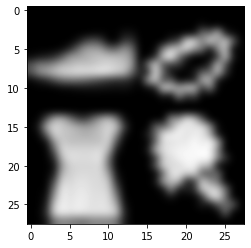

In [10]:
# Read a batch of data and their labels and display them
[imgs, labels] = (next(iter(val_loader)))
print(imgs.shape)
# imgs: [256, 1, 28, 28]
imgs = np.squeeze(imgs)
# imgs: [256, 28, 28]
print(imgs.shape)
plt.imshow(imgs[5].cpu().numpy(),cmap='gray',interpolation="bicubic") #.transpose()

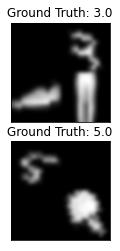

In [11]:
examples = enumerate(val_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(2):
  plt.subplot(2,1,i+1)
  # plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='bicubic')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
# fig

In [ ]:
# Here is a piece of code that reads data in batch.
# In each epoch all samples are read in batches using dataloader

num_epochs=2 # Feel free to change it
for epoch in range(num_epochs):
    for data in dataloader:
        [img,label] = data



## Tutorial CNN model

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Now, we have to create our network. This part is important in many aspects

In [13]:
class Net(nn.Module):
    # This part defines the layers
    def __init__(self):
        super(Net, self).__init__()
        # At first there is only 1 channel (greyscale). The next channel size will be 10. 
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # Then, going from channel size (or feature size) 10 to 20. 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # Now let us create some feed foreward layers in the end. Remember the sizes (from 320 to 50)
        self.fc1 = nn.Linear(320, 50)
        # The last layer should have an output with the same dimension as the number of classes
        self.fc2 = nn.Linear(50, 10)

    # And this part defines the way they are connected to each other
    # (In reality, it is our foreward pass)
    def forward(self, x):
        
        # F.relu is ReLU activation. F.max_pool2d is a max pooling layer with n=2
        # Max pooling simply selects the maximum value of each square of size n. Effectively dividing the image size by n
        # At first, x is out input, so it is 1x28x28
        # After the first convolution, it is 10x24x24 (24=28-5+1, 10 comes from feature size)
        # After max pooling, it is 10x12x12
        # ReLU doesn't change the size
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # Again, after convolution layer, size is 20x8x8 (8=12-5+1, 20 comes from feature size)
        # After max pooling it becomes 20x4x4
        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        # This layer is an imaginary one. It simply states that we should see each member of x
        # as a vector of 320 elements, instead of a tensor of 20x4x4 (Notice that 20*4*4=320)
        x = x.view(-1, 320)

        # Feedforeward layers. Remember that fc1 is a layer that goes from 320 to 50 neurons
        x = F.relu(self.fc1(x))

        # Output layer
        x = self.fc2(x)

        # We should put an appropriate activation for the output layer.
        return F.log_softmax(x)

Let's train these. But first, create the network, the optimizer and some lists for logging the training process

In [21]:
network = Net()
# optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
optimizer = optim.SGD(network.parameters(), lr=1, momentum=0.5)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(3)]

In [22]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    # this line is added to convert labels to LongTensor
    target = target.type(torch.LongTensor)
    # target = torch.argmax(target, dim=1) # convert from 1-hot to 1D

    loss = F.nll_loss(output, target) #negative log likelihood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in val_loader:
      output = network(data)
      # this line is added to convert labels to LongTensor
      target = target.type(torch.LongTensor)
      # target = torch.argmax(target, dim=1) # convert from 1-hot to 1D

      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(val_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(val_loader.dataset),
    100. * correct / len(val_loader.dataset)))

And let us train the network

In [23]:
for epoch in range(1, 40):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305449
Train Epoch: 1 [5120/60000 (11%)]	Loss: 2.314651
Train Epoch: 1 [10240/60000 (21%)]	Loss: 2.288024
Train Epoch: 1 [15360/60000 (32%)]	Loss: 2.197405
Train Epoch: 1 [20480/60000 (43%)]	Loss: 2.105079
Train Epoch: 1 [25600/60000 (53%)]	Loss: 2.475869
Train Epoch: 1 [30720/60000 (64%)]	Loss: 2.299184
Train Epoch: 1 [35840/60000 (74%)]	Loss: 2.208092
Train Epoch: 1 [40960/60000 (85%)]	Loss: 2.310310
Train Epoch: 1 [46080/60000 (96%)]	Loss: 2.307070


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4606, Accuracy: 1190/60000 (2%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.303239
Train Epoch: 2 [5120/60000 (11%)]	Loss: 2.298651
Train Epoch: 2 [10240/60000 (21%)]	Loss: 2.300265
Train Epoch: 2 [15360/60000 (32%)]	Loss: 2.306532
Train Epoch: 2 [20480/60000 (43%)]	Loss: 2.300159
Train Epoch: 2 [25600/60000 (53%)]	Loss: 2.298932
Train Epoch: 2 [30720/60000 (64%)]	Loss: 2.305143
Train Epoch: 2 [35840/60000 (74%)]	Loss: 2.303393
Train Epoch: 2 [40960/60000 (85%)]	Loss: 2.301753


KeyboardInterrupt: ignored

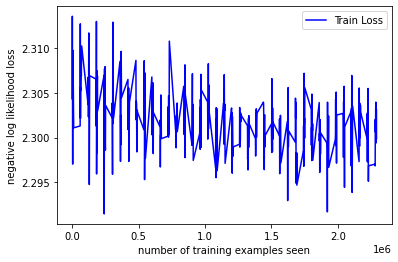

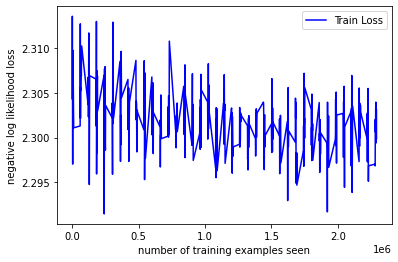

In [17]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')